<a href="https://colab.research.google.com/github/vbipin/aip/blob/master/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
#########
#This notebook has both decision tree and the Random forest classifier
#########

In [79]:
#Ref: https://www.cs.ubc.ca/~nando/540-2013/lectures.html
#lectures on Decision trees and Random forests
# http://www.cs.ubc.ca/~nando/540-2013/lectures/l8.pdf
# http://www.cs.ubc.ca/~nando/540-2013/lectures/l9.pdf

#Ref: Paper Criminisi et al, 2011
# https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/decisionForests_MSR_TR_2011_114.pdf

In [80]:
#In this we are exploring the decision tree algorithm
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [81]:
from collections import Counter
#from scipy.stats import entropy

In [82]:
#Some util functions

#we can use from scipy.stats import entropy
def entropy( P ) :    
    #make sure that the incoming is a probability dist
    assert( abs(sum(P) - 1) < 0.0001 ) #sum(P) must be 1; sometimes because of float values it need not be exactly 1
    
    sum_all = 0
    for p in P :
        sum_all += -p * np.log2(p) #entropy is the sum of -p*log(p)
    
    return sum_all

def p_from_count( n_count ) :
    """create a probability from counts like [1,3,4]"""
    N = sum(n_count)
    return [i/N for i in n_count]

def p_from_n_items( n_items ) :
    """count the items and build the probability distribution"""
    c = Counter(n_items)
    return p_from_count([c[i] for i in sorted(c.keys())])

#We also keep the probabilitu distribution as a dict
#p_dict = { label1 : probability1, label2 : probability2, ...}
def p_dict_from_n_items( n_items ) :
    """return a dict of {class: probability, ...}"""
    c = Counter(n_items)
    N = sum(c.values())
    p_dict = {label:count/N for label,count in c.items() }
    return p_dict

def entropy_from_n_items( n_items ) :
    """entropy form a list like [0,0,1,0,2,2]"""
    if len(n_items) == 0 :
        return 0 #we assume the entropy of a null list is 0 #XXX
    return entropy( p_from_n_items( n_items ) )


def data_split( X, Y, index_list ) :
    """Returns new X,Y at the indexs"""
    return X[index_list], Y[index_list] #worls only with numpy arrays



In [83]:
#some more utils for random forests
def argmax_of_p_dict( p_dict ) :
    """returns the key to the max value in the dict"""
    return max(p_dict, key=lambda key: p_dict[key])

#We need to average all the probability dicts from all the decition trees
#   to get the final randomforest prediction.
#ref: Criminisi et al, 2011
def average_list_of_p_dict( list_of_dict ) :
    """make an average of lot of dicts"""
    new_dict = {}
    for d in list_of_dict :
        for k,v in d.items() :
            if k in new_dict :
                new_dict[k] += v
            else :
                new_dict[k] = v
    T = len(list_of_dict)
    return {k:v/T for k,v in new_dict.items()} #return the average

In [84]:
#we split a continuous variable according to a value in to left and right trees
#left branch is < 

def split_continuous_feature( data, split_value ) :
    #we return the left indexs, and right nodes based on the split values
    #np.where just gives the index
    left_indexs  = np.where( data < split_value )
    right_indexs = np.where( data >= split_value )
    return left_indexs, right_indexs


In [150]:
#information gain and GINI

def information_gain( parent, child_list ) :
    """ parent is the list of y values
        child_list is the list of y values for each child node
    """
    parent_entropy = entropy_from_n_items(parent)
    #for expectation we need each child probability
    child_probability = [ len(c)/len(parent)      for c in child_list]
    child_entropy     = [ entropy_from_n_items(c) for c in child_list ]
    children_expected_entropy = sum( [child_probability[i] * child_entropy[i] for i in range(len(child_list)) ] )
    
    return parent_entropy - children_expected_entropy

#ref : https://victorzhou.com/blog/gini-impurity/
#Fixed a BUG :)
def gini( n_items ) :
    probability_dist = p_from_n_items( n_items )
    return 1 - sum([p**2 for p in probability_dist])

def gini_gain( parent, child_list ) :
    """ parent is the list of y values
        child_list is the list of y values for each child node
    """
    #for expectation we need each child probability
    child_probability = [ len(c)/len(parent)      for c in child_list]
    children_expected_gini = sum( [child_probability[i] * gini(child_list[i]) for i in range(len(child_list)) ] )
    
    return gini(parent) - children_expected_gini

In [152]:
X = np.array([ 
    [1,1,3], 
    [1.5,1,5],
    [1,1.5,5],
    [3,1.5,7],
    [2,2.5,6],
    [3,3,2],
])
Y = np.array([1,1,1,1,0,0])

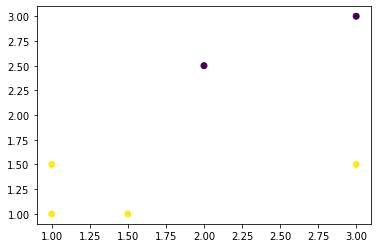

In [153]:
plt.scatter(X[:,0], X[:,1], c=Y)

In [154]:
for split_value in [1, 1.2, 1.7,2.2,3,3.5] :
    feature_index = 0
    l_index,r_index =split_continuous_feature(X[:, feature_index], split_value)
    L = Y[l_index]
    R = Y[r_index]
    #print(len(L), len(R))
    print( information_gain(Y,[L,R]), gini_gain(Y,[L,R]) )
    
for split_value in [1, 1.2, 1.5, 2,3,3.5] :
    feature_index = 1
    l_index,r_index =split_continuous_feature(X[:, feature_index], split_value)
    L = Y[l_index]
    R = Y[r_index]
    #print(len(L), len(R))
    print( information_gain(Y,[L,R]), gini_gain(Y,[L,R]) ) 

0.0 0.0
0.2516291673878229 0.1111111111111111
0.4591479170272448 0.2222222222222222
0.044110417748401076 0.02777777777777779
0.044110417748401076 0.02777777777777779
0.0 0.0
0.0 0.0
0.2516291673878229 0.1111111111111111
0.2516291673878229 0.1111111111111111
0.9182958340544896 0.4444444444444444
0.31668908831502096 0.17777777777777787
0.0 0.0


In [89]:
########################################################################
#Lets proceed with finding the best feature and its split value

In [90]:
"""
#We need to find the best split of a feature. The features are split according to the values
# and evaluted on the information gain (or GINI)
# The best split is taken forward to build the tree node.

#First how many split points are we considering?
#For simplicity we can consider all the values. This may be n overkill.
#A better method may be to quantize the range of values.
"""

def find_split_values( X, feature_index) :
    """return a set of all values that can be used for splitiing the data"""
    #For the time being we are just returning all the values
    #ie value of this column for all data points.
    return X[:, feature_index]

def find_best_split(X,Y, feature_list=None, criterion=information_gain ) :
    """Find the best split among the given feature indexes
        feature_list: list of indexs eg [ 0, 5, 7, 20]
        criterion:    function to use for spliting information_gain or gini
    """
    #if no feature list is given we take all the features of the data
    if feature_list is None : 
        feature_list = range(len(X[0])) #all the features
    
    ig_list = [] #we store the IGvalue, feature_index, and split_value
    for feature_index in feature_list :
        #for this feature, we find the information_gain for all the splits
        split_values = find_split_values( X, feature_index)
        for value in split_values : 
            #split the data into left and right according to the value
            l_index, r_index = split_continuous_feature(X[:, feature_index], value)
            L = Y[l_index]
            R = Y[r_index]
            
            #criterion is information_gain or gini
            ig_list.append( (criterion(Y,[L,R]), feature_index, value) ) 

    return sorted(ig_list)[-1] #this will be sorted on ig; so last one will be the best



In [91]:
#Tree node
#We store the feature index, the value to split on and the probability dict at that node
class node :
    def __init__(self, feature_index, split_value, p_dict) :
        self.feature_index = feature_index
        self.split_value   = split_value
        self.p_dict        = p_dict # { label1: probability, label2: probability, ...  }
        self.L = None  # < split_value
        self.R = None  # >= split_value
        

In [92]:
"""
The decision tree is buitl taking a max_depth and number of features as input.
"""        
def build_decision_tree( PX, PY, depth, num_features=None, criterion=information_gain) :
    
    if depth <= 0 or len(PY) == 0 :
        return None
    
    #we willr andomly selct some features to consider at this node.
    if num_features is None : #we take all features
        feature_list = list(range(PX.shape[1]))
    else :
        feature_list = np.random.choice( range(PX.shape[1]), num_features, replace=False)
   
    #f is the best feature index and v is the value to split on
    _,f,v = find_best_split(PX,PY, feature_list, criterion)
    
    #create the tree node with f, v and p_dict
    tree = node( f, v, p_dict_from_n_items( PY ) )
    
    #Do we have only one label? Then it is a leaf node
    if len(tree.p_dict.keys()) <= 1 :
        return tree #we dont need to split this node
        
    l_index,r_index =split_continuous_feature(PX[:, f], split_value=v)
    
    #left tree
    LX, LY = data_split(PX,PY,l_index)
    tree.L = build_decision_tree( LX, LY, depth-1, num_features, criterion )
    
    #right tree   
    RX, RY = data_split(PX,PY,r_index)
    tree.R = build_decision_tree( RX, RY, depth-1, num_features, criterion )
    
    return tree
        
def find_leaf_node( node, x ) :
    """find the leaf node of the data point x"""
    
    if x[node.feature_index] < node.split_value : #left tree
        #Do we have a left tree?
        if node.L is not None :
            return find_leaf_node( node.L, x )
    else :
        if node.R is not None :
            return find_leaf_node( node.R, x )
    #there is no downward tree for this x; then the current node is the leaf
    return node

def tree_predict( tree, x ) :
    """This will return the label of the data point x"""
    node = find_leaf_node( tree, x )    
    return prediction_from_p_dict(node.p_dict) #, node.p_dict

#To predict the label forma probability distribution, we take the argmax
#ie we choose the label with the highest probability
def prediction_from_p_dict( p_dict ) :
    return argmax_of_p_dict( p_dict )


#def predict( node, x ) :
#    prediction, p_dict = tree_predict( node, x )
#    return prediction

(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


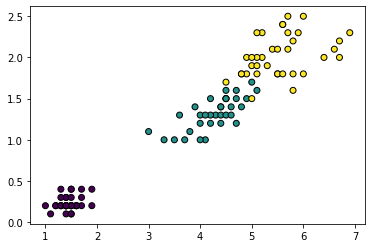

In [93]:
#############################################
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()

print(iris.data.shape)
print(iris.feature_names)
print(iris.target_names)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3) # 70% training and 30% test

#X = iris.data
#Y = iris.target

X=X_train
Y=y_train

plt.scatter(X[:, 2], X[:, 3],
               c=Y.astype(np.float), edgecolor='k')

In [94]:
#Work in progress. Just a backup

In [95]:
def accuracy( predicted, true ) :
    return list(predicted == true).count(True)/len(predicted)

In [96]:
tree = build_decision_tree( X, Y, 5)

In [97]:
y_ = [ tree_predict(tree, X[i]) for i in range(len(X)) ]
accuracy(y_, y_train)

0.9809523809523809

In [98]:
t_ = [ tree_predict(tree, X_test[i]) for i in range(len(X_test)) ]
accuracy(t_, y_test)

0.9111111111111111

In [99]:
#############################################################
#Cancer dataset

In [141]:
#ref: https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
from sklearn.datasets import load_breast_cancer
b = load_breast_cancer()

print(b.data.shape)
print(b.feature_names)
print(b.target_names)

(569, 30)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


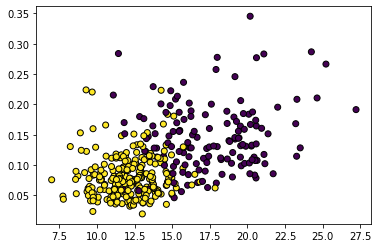

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(b.data, b.target, test_size=0.3) # 70% training and 30% test

#X = iris.data
#Y = iris.target

X=X_train
Y=y_train

plt.scatter(X[:, 0], X[:, 5],
               c=Y.astype(np.float), edgecolor='k')

In [143]:
tree = build_decision_tree( X, Y, depth=5)
y_ = [ tree_predict(tree, X[i]) for i in range(len(X)) ]

print( accuracy(y_, y_train) ) #Accuracy on training data

0.9748743718592965


In [144]:
t_ = [ tree_predict(tree, X_test[i]) for i in range(len(X_test)) ]

print( accuracy(t_, y_test) ) #On TEST data

0.9532163742690059


In [104]:
#################################################################

In [105]:
#################################################################
# Random forests

In [106]:
def build_forest(X, Y, num_trees, max_depth, num_features=None, criterion=information_gain) :
    forest = []
    for _ in range(num_trees) :
        
        #First we randomly choose a set of fetures for this tree
        #we slect the random features when we create each tree node.

        #For boosting we sample the dataset with replace=True
        row_list     = np.random.choice( range(X.shape[0]), size=X.shape[0], replace=True)
        #split the data according to the boosting
        new_x, new_y = data_split( X, Y, row_list ) #, feature_list)
        
        tree = build_decision_tree( new_x, new_y, max_depth, num_features, criterion)

        forest.append(tree)
        
    return forest

In [107]:
def forest_predict(forest, X_test) :
    """returns the predicted labels"""

    outcome = []
    for i in range(len(X_test)) :  
        #we collect the p_dicts from each tree for this data point      
        all_p_dicts = [ find_leaf_node(tree, X_test[i]).p_dict for tree in forest ]
        #take an average of the proability dist
        p_dict = average_list_of_p_dict( all_p_dicts )
        #Now, find the prediction from this new averaged p_dict
        t_ = prediction_from_p_dict( p_dict )
        outcome.append(t_)
    
    return np.array(outcome)


In [108]:
#util function to find the accuracy of the forest classifier        
def find_accuracy( forest, X_test, y_test ) : 
    t_ = forest_predict(forest, X_test)
    return accuracy(t_, y_test)

In [145]:
#We change the number of features and depth of each tree
#
#Let T be the number of trees 
num_trees = 30
num_features = 4 #we take only few features per tree
#boosting     = True
max_depth    = 2

In [146]:
np.random.seed(1)
forest = build_forest(X_train,y_train, num_trees,  max_depth, num_features)

In [147]:
find_accuracy( forest, X_test, y_test)

0.9181286549707602

In [148]:
#with GINI index
np.random.seed(1)
forest = build_forest(X_train,y_train, num_trees,  max_depth, num_features, gini_gain)
find_accuracy( forest, X_test, y_test)

0.9181286549707602

In [113]:
#############################################################################

In [114]:
####### RF from Sklearn ######################################################

In [115]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, max_features=3, random_state=0, criterion='entropy', n_estimators=10)

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=3, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [116]:
t_ = clf.predict(X_test)
print( accuracy(t_, y_test) )

0.9590643274853801
